
# Import Library
---



In [ ]:
import tensorflow as tf
import os
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Splitting Data

In [ ]:
dataset_dir = "/content/drive/MyDrive/data"
categories = ["normal", "oily", "dry"]

base_dir = os.path.join(dataset_dir + "/Splitted")

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Membuat direktori output
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for category in categories:
#     # Mendapatkan path ke gambar
    category_dir = os.path.join(dataset_dir, category)
    images = os.listdir(category_dir)
    images = [os.path.join(category_dir, img) for img in images]

#     # Membagi data menjadi train, val, test
    train_images, temp_images = train_test_split(images, test_size=0.4, random_state=42)  # 70% train
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)  # 15% val, 15% test

#     # Membuat direktori untuk kategori
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

#     # Memindahkan gambar
    for img in train_images:
        shutil.copy(img, os.path.join(train_dir, category))
    for img in val_images:
        shutil.copy(img, os.path.join(val_dir, category))
    for img in test_images:
        shutil.copy(img, os.path.join(test_dir, category))

In [ ]:
batch_size = 32
image_size = (224, 224)

# Memuat dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size = image_size,
    batch_size = batch_size,
    label_mode = "categorical"  # Karena ada 3 kategori
)

# Simpan class name sebelum prefetch
class_names = train_dataset.class_names

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size = image_size,
    batch_size = batch_size,
    label_mode = "categorical"
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size = image_size,
    batch_size = batch_size,
    label_mode = "categorical"
)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size = AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

Found 762 files belonging to 3 classes.
Found 254 files belonging to 3 classes.
Found 257 files belonging to 3 classes.


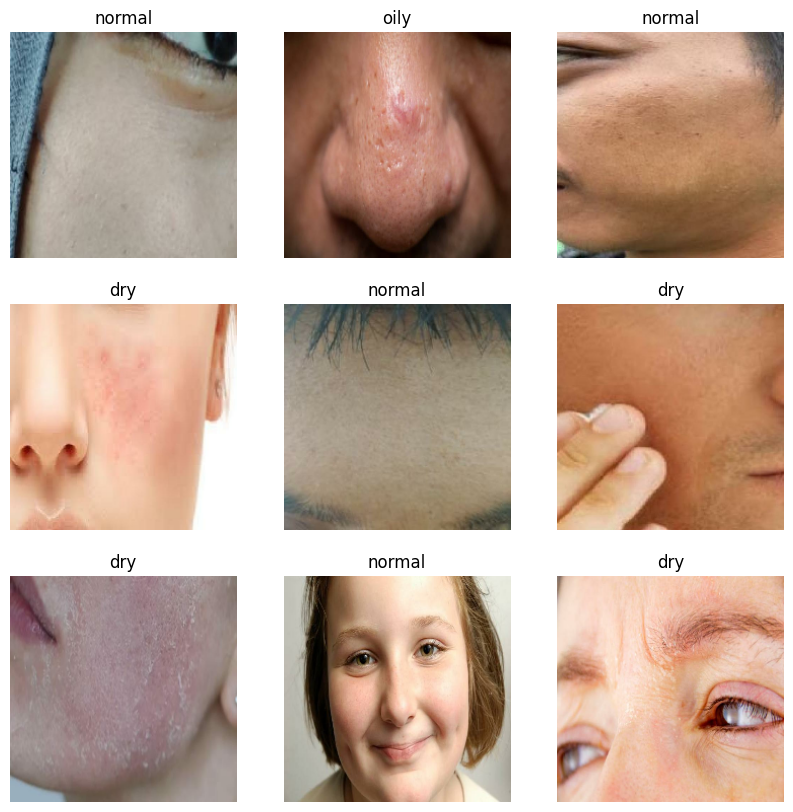

In [ ]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i]).numpy()])
        plt.axis("off")
    plt.show()

# Augmentasi Data

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained MobileNetV2
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model layers

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# Model

Enabling GPU Process

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(False)

Num GPUs Available:  1


Menggunakan pretrained model

In [ ]:
from tensorflow.keras.layers import Dropout
# Add custom layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: dry, normal, oily
])

## Custom Layers

# Compile Model

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale = 1 / 255,
    rotation_range = 40,
    zoom_range = .2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

train_generator = datagen.flow_from_directory(
    train_dir,
    batch_size = 32,
    class_mode = 'categorical',
    target_size = (224, 224)
)


valid_generator = datagen.flow_from_directory(
    val_dir,
    batch_size=32,
    class_mode='categorical',
    target_size=(224, 224)
)

Found 762 images belonging to 3 classes.
Found 254 images belonging to 3 classes.


In [ ]:
history = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 25
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.4604 - loss: 1.3292 - val_accuracy: 0.5787 - val_loss: 0.8821
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 580ms/step - accuracy: 0.6240 - loss: 0.8289 - val_accuracy: 0.6575 - val_loss: 0.7895
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 27s 790ms/step - accuracy: 0.6981 - loss: 0.7077 - val_accuracy: 0.6929 - val_loss: 0.7523
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 597ms/step - accuracy: 0.7130 - loss: 0.6471 - val_accuracy: 0.6969 - val_loss: 0.7474
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 640ms/step - accuracy: 0.7473 - loss: 0.6213 - val_accuracy: 0.6969 - val_loss: 0.7001
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 593ms/step - accuracy: 0.7492 - loss: 0.5550 - val_accuracy: 0.7244 - val_loss: 0.6778
Epoch 7/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 566ms/step - accuracy: 0.7734 - loss: 0.5559 - val_accuracy: 0.7323 - val_loss: 0.7011
Epoch 8/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 581ms/step - accuracy: 0.7800 - loss: 0.5302 - val_accuracy: 0.7480 -

In [ ]:
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Evaluate
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

Found 257 images belonging to 3 classes.
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 744ms/step - accuracy: 0.7778 - loss: 0.5092
Test Accuracy: 0.79


## Model Accuracy

# Visualisasi

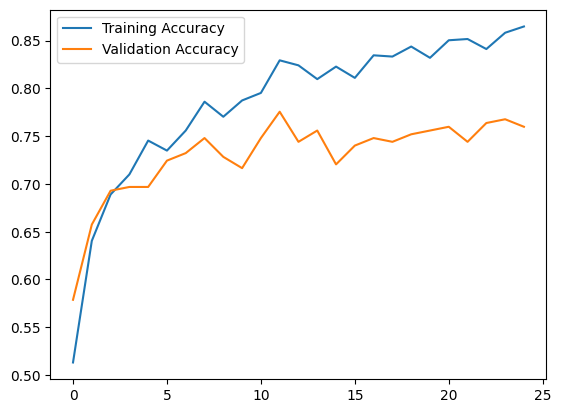

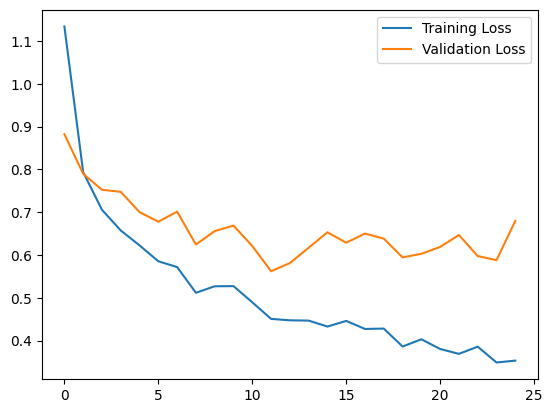

In [ ]:
# Plot akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


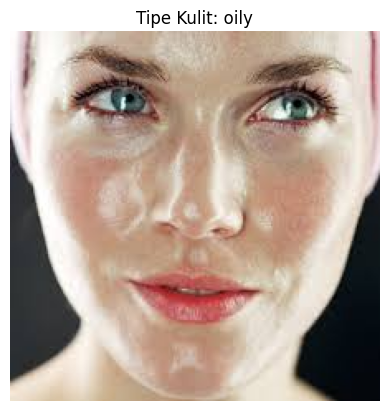

Tipe Kulit Prediksi: oily


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Fungsi untuk memprediksi gambar
def predict_image(model, img_path, class_labels):
    # Muat gambar dan ubah ukurannya ke (224, 224)
    img = image.load_img(img_path, target_size=(224, 224))

    # Konversi gambar ke array numpy
    img_array = image.img_to_array(img)

    # Normalisasi gambar (rescale seperti pada ImageDataGenerator)
    img_array = img_array / 255.0

    # Tambahkan dimensi batch
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    predictions = model.predict(img_array)

    # Ambil indeks prediksi tertinggi
    predicted_index = np.argmax(predictions[0])

    # Dapatkan label kelas
    predicted_label = class_labels[predicted_index]

    # Plot gambar dengan label prediksi
    plt.imshow(img)
    plt.title(f"Tipe Kulit: {predicted_label}")
    plt.axis('off')
    plt.show()

    return predicted_label

# Daftar label kelas (urutkan sesuai dengan `train_generator.class_indices`)
class_labels = list(train_generator.class_indices.keys())

# Jalankan fungsi prediksi
image_path = "/content/drive/MyDrive/foto/minyak.jpeg"  # Ganti dengan path gambar yang ingin diuji
predicted_class = predict_image(model, image_path, class_labels)

print(f"Tipe Kulit Prediksi: {predicted_class}")


In [ ]:
model.save('skin_type_model.h5')